In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import statsmodels.api as stm
import statsmodels
import arch.data.frenchdata
import matplotlib.pyplot as plt
from arch.unitroot import VarianceRatio
from hurst import compute_Hc, random_walk
import warnings
warnings.filterwarnings("ignore")

In [2]:
%load_ext rpy2.ipython
%R install.packages("randtests")
%R library(randtests)

--- Please select a CRAN mirror for use in this session ---
Secure CRAN mirrors 

 1: 0-Cloud [https]
 2: Australia (Canberra) [https]
 3: Australia (Melbourne 1) [https]
 4: Australia (Melbourne 2) [https]
 5: Australia (Perth) [https]
 6: Austria [https]
 7: Belgium (Brussels) [https]
 8: Brazil (BA) [https]
 9: Brazil (PR) [https]
10: Brazil (RJ) [https]
11: Brazil (SP 1) [https]
12: Brazil (SP 2) [https]
13: Bulgaria [https]
14: Canada (MB) [https]
15: Canada (ON 2) [https]
16: Canada (ON 3) [https]
17: Chile (Santiago) [https]
18: China (Beijing 2) [https]
19: China (Hefei) [https]
20: China (Hong Kong) [https]
21: China (Guangzhou) [https]
22: China (Lanzhou) [https]
23: China (Nanjing) [https]
24: China (Shanghai 1) [https]
25: China (Shanghai 2) [https]
26: China (Shenzhen) [https]
27: Costa Rica [https]
28: Cyprus [https]
29: Czech Republic [https]
30: Denmark [https]
31: East Asia [https]
32: Ecuador (Cuenca) [https]
33: Ecuador (Quito) [https]
34: Estonia [https]
35: France 

R[write to console]: Warning:
R[write to console]:  unable to access index for repository https://nbcgib.uesc.br/mirrors/cran/src/contrib:
  cannot open URL 'https://nbcgib.uesc.br/mirrors/cran/src/contrib/PACKAGES'

R[write to console]: Warning:
R[write to console]:  unable to access index for repository https://nbcgib.uesc.br/mirrors/cran/bin/macosx/el-capitan/contrib/3.6:
  cannot open URL 'https://nbcgib.uesc.br/mirrors/cran/bin/macosx/el-capitan/contrib/3.6/PACKAGES'



'randtests','tools','stats',...,'datasets','methods','base'


In [3]:
df1= pd.read_excel('/Users/Catalina/Desktop/crypto_jumps/DateCrypto.xlsx', sheet_name= 'BITFINEX_BTC')
df2= pd.read_excel('/Users/Catalina/Desktop/crypto_jumps/DateCrypto.xlsx', sheet_name= 'COINBASE_BTC')

## Jump detection

In [4]:
def DetectJump(DataFrame,K):
    """
    DataFrame should be a dataframe with two columns:
    First column: calendar date, type pandas.Timestamp
    Second column: values for the data to be tested
    
    K is the sample size to compute the local volatility
    """
    Dates=DataFrame.iloc[:,0]
    Levels=DataFrame.iloc[:,1]
    Values = np.log(Levels)-np.log(Levels.shift(1)) #Compute log-returns
    Values.drop(index=Values.index[0], inplace=True) #Drop first row in Values
    Dates.drop(index=Dates.index[0], inplace=True) #Drop first row in Dates
    Levels.drop(index=Levels.index[0], inplace=True)
    
    SigmaHat_t=np.nan*np.zeros(len(Values)-K+1)
    J_i = np.nan*np.zeros(len(Values)-K+1)
    Jumps=pd.DataFrame(J_i, index=Dates.iloc[K-1:], columns=['J_i'])
    Jumps['Jumps']=0
    Jumps['Levels']=Levels.iloc[K-1:].values
    Jumps['Returns']=Values.iloc[K-1:].values
    
    
    for i in range(K-1,len(Values)):
        ProductsForSum=[np.abs(Values.iloc[m])*np.abs(Values.iloc[m-1]) for m in range(i-K+2-1,i-1)]
        SigmaHatSq_ti = (1/(K-2))*np.sum(ProductsForSum)
        
        nj=len(ProductsForSum)
        c=0.7979
        Cnj=(np.sqrt(2*np.log(nj)))/c - (np.log(np.pi)+np.log(np.log(nj)))/(2*c*np.sqrt(2*np.log(nj)))
#         print('Cnj is',Cnj)
        Snj=1/(c*np.sqrt(2*(np.log(nj))))
#         print('Snj is',Snj)
        L_i = Values.iloc[i]/np.sqrt(SigmaHatSq_ti)
#         print('L_i is',L_i)
        J_i[i-K+1] = (np.abs(L_i)-Cnj)/Snj
#         print('J_i is', J_i)
        Threshold = 4.6001
        
    
    IDjumps=Jumps[Jumps['J_i'] > Threshold].index
    Jumps['Jumps'][IDjumps]=1
    Jumps['LevelsWithJumps']=np.nan
    Jumps['LevelsWithJumps'][IDjumps]=Jumps['Levels'][IDjumps]
    Jumps['ReturnsWithJumps']=np.nan
    Jumps['ReturnsWithJumps'][IDjumps]=Jumps['Returns'][IDjumps]
    return Jumps
    

In [5]:
df1= df1.drop(columns= ['Open', 'High', 'Low', 'Volume', 'No.Trades'])
df2= df2.drop(columns= ['Open', 'High', 'Low', 'Volume', 'No.Trades'])

In [6]:
#fixez rw(k=16) min 
K=16
jumps_bitfinex= DetectJump(df1, K)
jumps_coinbase= DetectJump(df2, K)

## Plot jumps

In [7]:
import plotly.graph_objects as go

fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=jumps_bitfinex.index, y=jumps_bitfinex['Levels'],
                    mode='lines',
                    name='Levels'))
fig.add_trace(go.Scatter(x=jumps_bitfinex.index, y=jumps_bitfinex['LevelsWithJumps'],
                    mode='markers',
                    name='Jumps'))
fig.show()

In [8]:
fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=jumps_coinbase.index, y=jumps_coinbase['Levels'],
                    mode='lines',
                    name='Levels'))
fig.add_trace(go.Scatter(x=jumps_coinbase.index, y=jumps_coinbase['LevelsWithJumps'],
                    mode='markers',
                    name='Jumps'))
fig.show()

## No of jumps

In [9]:
#count the no of jumps for each exchange
def JumpCount(dataFrame):
    nr = 0
    for index,row in dataFrame.iterrows():
        if (row['Jumps'] == 1): nr+=1
    return nr

In [10]:
print('#jumps bitfinex:', JumpCount(jumps_bitfinex))
print('#j coinbase:', JumpCount(jumps_coinbase))

#jumps bitfinex: 47
#j coinbase: 56


## Plot retrurns & jumps

In [11]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x= jumps_bitfinex.index, y=jumps_bitfinex['Returns'],
                    mode='lines',
                    name='Returns'))
fig.add_trace(go.Scatter(x= jumps_bitfinex.index, y= jumps_bitfinex['ReturnsWithJumps'],
                    mode='markers',
                    name='Jumps'))

fig.show()

In [12]:
fig = go.Figure()

# Add traces
fig.add_trace(go.Scatter(x= jumps_coinbase.index, y=jumps_coinbase['Returns'],
                    mode='lines',
                    name='Returns'))
fig.add_trace(go.Scatter(x= jumps_coinbase.index, y= jumps_coinbase['ReturnsWithJumps'],
                    mode='markers',
                    name='Jumps'))

fig.show()

In [13]:
jumps_bitfinex.to_excel('jumps_bitfinex.xlsx')
jumps_coinbase.to_excel('jumps_coinbase.xlsx')

In [14]:
#remove jumps from data
def JumpRemove(dataFrame):
    return dataFrame.drop(dataFrame[dataFrame.Jumps == 1].index)

In [15]:
nojumps_bitfinex = JumpRemove(jumps_bitfinex)
nojumps_bitfinex.head()

,J_i,Jumps,Levels,Returns,LevelsWithJumps,ReturnsWithJumps
Date,,,,,,
2015-06-09,-3.977746,0,229.06,0.001311,NaN,NaN
2015-06-10,-3.876819,0,228.60,-0.002010,NaN,NaN
2015-06-11,-3.181151,0,230.00,0.006106,NaN,NaN
2015-06-12,-3.887170,0,229.55,-0.001958,NaN,NaN
2015-06-13,-1.785360,0,232.87,0.014359,NaN,NaN


In [16]:
nojumps_coinbase= JumpRemove(jumps_coinbase)
nojumps_coinbase.head()

,J_i,Jumps,Levels,Returns,LevelsWithJumps,ReturnsWithJumps
Date,,,,,,
2015-06-17,-2.352591,0,250.20,-0.006414,NaN,NaN
2015-06-18,-3.461409,0,249.27,-0.003724,NaN,NaN
2015-06-19,-2.154855,0,246.36,-0.011743,NaN,NaN
2015-06-20,-4.057482,0,246.13,-0.000934,NaN,NaN
2015-06-21,-3.185956,0,244.66,-0.005990,NaN,NaN


In [17]:
nojumps_bitfinex.to_excel(excel_writer= '0jumps.xlsx', sheet_name= 'no_jumps_bitfinex')
nojumps_coinbase.to_excel(excel_writer= '0jumps.xlsx', sheet_name='no_jumps_coinbase')
with pd.ExcelWriter('0jumps.xlsx') as writer:  
    nojumps_bitfinex.to_excel(writer, sheet_name='no_jumps_bitfinex')
    nojumps_coinbase.to_excel(writer, sheet_name='no_jumps_coinbase')

## Tests used for testing EMH

In [18]:
def lung_box(returns):
   return stm.stats.diagnostic.acorr_ljungbox(returns, lags=[10], boxpierce=False)

def runs_test(returns):
  ret= pd.Series.to_numpy(returns)
  return statsmodels.sandbox.stats.runs.runstest_1samp(ret, cutoff='median', correction= True)

def hurst_exponent(returns):
  return compute_Hc(returns, kind= 'random_walk', simplified=True)

def bds(returns):
  return statsmodels.tsa.stattools.bds(returns, max_dim=2, epsilon=None, distance=1.5)

## P-value calculation using a rolling window

In [19]:
def RollingWindows(all_returns, rollingWindow):
  df = pd.DataFrame()
  for i in range (rollingWindow,len(all_returns)):
      returns = all_returns[i-rollingWindow:i]
      pvalue = []
      pvalue.append((lung_box(returns)[1]).item(0))
      pvalue.append(runs_test(returns)[1])
      pvalue.append(VarianceRatio(returns, 100).pvalue)
      pvalue.append((bds(returns)[1]).item(0))
      pvalue.append(hurst_exponent(returns)[0])
      %Rpush returns
      %R bartels = bartels.rank.test(returns, alternative= 'two.sided', pvalue='normal')
      bartels = %Rget bartels
      bartelsValue = bartels[5]
      pvalue.append(bartelsValue[0])
      x = pd.Series(pvalue)
      df = df.append(x,ignore_index=True)
  return df

## Crypto efficiency testing function

In [20]:
def CryptoEfficiency2(df,rollingWindow_size,excelName):
  writer = pd.ExcelWriter(excelName,engine='xlsxwriter')
  for i in range (0,len(df.sheet_names)):
    df_sheet = df.parse(i)
    all_returns = df_sheet['Returns']
    dff = RollingWindows(all_returns,rollingWindow_size)
    dff = dff.rename(columns = {0:'Ljung-Box',1:'RunsTest', 2:'VarianceRatio', 3: 'BDSTest', 4:'HurstExponent', 5:'BartelsTest'})
    dff.to_excel(writer,sheet_name=str(df.sheet_names[i]), index= False)
    print(df.sheet_names[i],' processed ', i+1,'/',len(df.sheet_names))
  writer.save()
  print('Saved as: ',excelName)

## Plot functions

In [21]:
#single plot
def PlotTables(data):
  fig, axs = plt.subplots(1,2)
  data['Ljung-Box'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Ljung Box Dynamic',ax=axs[0])
  data['RunsTest'].plot(xlabel= 'Rolling window = 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Runs Test Dynamic',ax=axs[1])
  plt.show()
  fig, axs = plt.subplots(1,2)
  data['VarianceRatio'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Variance Ratio Dynamic',ax=axs[0])
  data['BartelsTest'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(17,6), title= 'P-value Bartels Test Dynamic',ax=axs[1])
  plt.show()
  data['BDSTest'].plot(xlabel= 'Rollling window= 250', ylabel= 'P-value', figsize=(17,6), title= 'P-value BDS Test Dynamic')
  plt.show()
  data['HurstExponent'].plot(xlabel= 'Rolling window= 250', ylabel= "Hurst Exponent", figsize=(17,6), title= 'Hurst Exponent Dynamic')
  plt.show()

#overlapping plots
def PlotTables2(data):
  data['Ljung-Box'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(6,4),label='Ljung')
  data['VarianceRatio'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(6,4),label='Variance')
  plt.legend()
  plt.show()
  data['RunsTest'].plot(xlabel= 'Rolling window = 250', ylabel= "P-value", figsize=(6,4),label='Runs')
  data['BartelsTest'].plot(xlabel= 'Rolling window= 250', ylabel= "P-value", figsize=(6,4),label='Bartels')
  plt.legend()
  plt.show()
  data['BDSTest'].plot(xlabel= 'Rolling window = 250', ylabel= "P-value", figsize=(6,4),label='BDS')
  plt.legend()
  plt.show()
  data['HurstExponent'].plot(xlabel= 'Rolling window= 250', ylabel= "Hurst Exponent", figsize=(12,4), title= 'Hurst Exponent Dynamic')
  plt.legend()
  plt.show()

#cases
def PrintTablesForExcel(data,j):
  for i in range (0,len(data.sheet_names)):
    df_sheet = data.parse(i)
    if df_sheet.empty:
      continue
    else:
      print(data.sheet_names[i])
      if(j == 1):
        PlotTables(df_sheet)
      else: PlotTables2(df_sheet)
      print('-------------------------------------')

#plot function
def AllTables(df,rollWindow,excelName,i):
  CryptoEfficiency2(df, rollWindow,excelName)
  data= pd.ExcelFile(excelName)
  PrintTablesForExcel(data,i)


no_jumps_bitfinex  processed  1 / 2
no_jumps_coinbase  processed  2 / 2
Saved as:  pvalues.xlsx
no_jumps_bitfinex


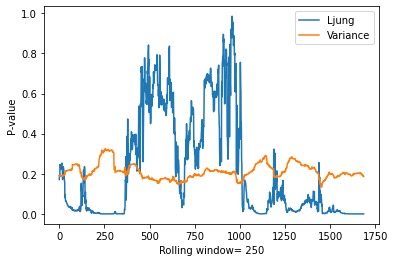

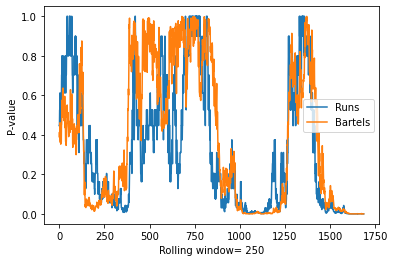

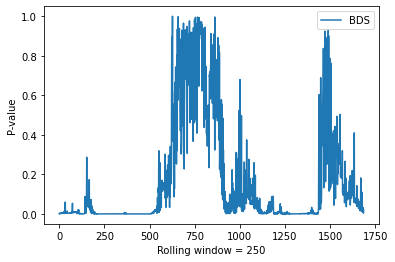

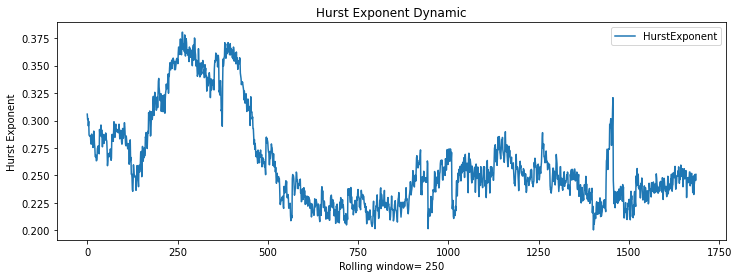

-------------------------------------
no_jumps_coinbase


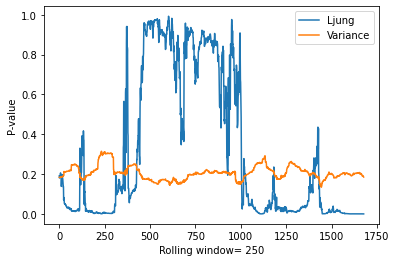

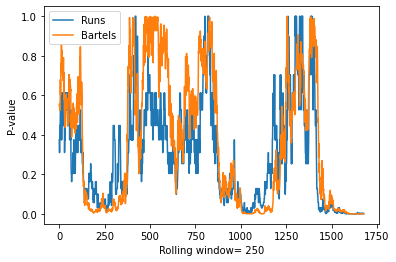

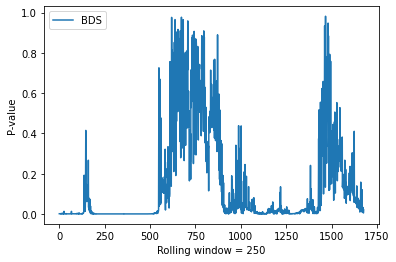

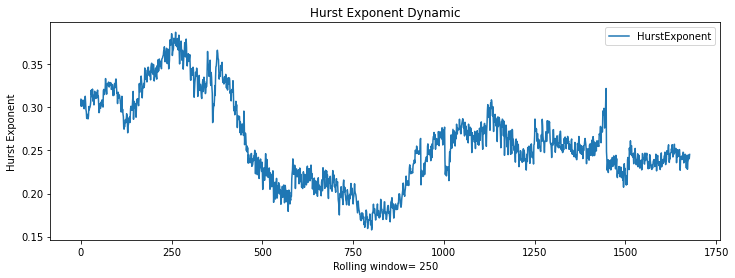

-------------------------------------


In [22]:
df_daily= pd.ExcelFile('/Users/Catalina/Desktop/crypto_jumps/0jumps.xlsx')

AllTables(df_daily, 250,'pvalues.xlsx', 2)